In [1]:
import random
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F

##from dlc_practical_prologue.py import *


# helpers

In [2]:

from torchvision import datasets
import argparse
import os

######################################################################

parser = argparse.ArgumentParser(description='DLC prologue file for practical sessions.')

parser.add_argument('--full',
                    action='store_true', default=False,
                    help = 'Use the full set, can take ages (default False)')

parser.add_argument('--tiny',
                    action='store_true', default=False,
                    help = 'Use a very small set for quick checks (default False)')

parser.add_argument('--seed',
                    type = int, default = 0,
                    help = 'Random seed (default 0, < 0 is no seeding)')

parser.add_argument('--cifar',
                    action='store_true', default=False,
                    help = 'Use the CIFAR data-set and not MNIST (default False)')

parser.add_argument('--data_dir',
                    type = str, default = None,
                    help = 'Where are the PyTorch data located (default $PYTORCH_DATA_DIR or \'./data\')')

# Timur's fix
parser.add_argument('-f', '--file',
                    help = 'quick hack for jupyter')

args = parser.parse_args()

if args.seed >= 0:
    torch.manual_seed(args.seed)

# GENERATE DATA

In [3]:
def normalize_data(train_input, test_input):
    """
    Normalize the data based on train mean and std
    Modifies input tensors.
    Args:
        train_input:    tensor size=[nbx2x14x14]
        test_input:     tensor size=[nbx2x14x14]
    Returns:
        -

    """
    mu, std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    test_input.sub_(mu).div_(std)


def to_one_hot(tensor):
    """
    Generates vector in one hot coding
    Args:
        tensor: tensor of class values (int from 0 to 9) size=[nb]
    Returns:
        tensor of size              size=[nbx10]
    """
    one_hot = torch.zeros((tensor.size(0), 10)).type(torch.FloatTensor)
    one_hot[list(range(0, tensor.size(0))), tensor[:, 0]] = 1
    return one_hot


def shuffle(t_input, classes, target):
    """
    Shuffle data randomly maintaining the relation between input, classes and target
    Args:
        t_input:    tensor of size=[nbx2x14x14]
        classes:    tensor of size=[nbx10] (already in one-hot format)
        target:     tensor of size=[nb] or size=[nbx2] if converted binary
    Returns:
        shuffled t_input, classes, target

    """
    idx = [i for i in range(t_input.size(0))]
    random.shuffle(idx)
    if len(target.shape) == 1:
        return t_input[idx, :, :, :], classes[idx, :], target[idx]
    else:
        return t_input[idx, :, :, :], classes[idx, :], target[idx,:]


def binarize(target):
    """
    Binarize target tensor
    Args:
        target:     tensor of size=[nb] and values [0,1]
    Returns:
        target_bin:  tensor of size=[nbx2]
    """
    target_bin = torch.zeros((target.size(0), 2))
    target_bin[list(range(target.size(0))), target[:]] = 1
    return target_bin


# LOAD DATA

In [4]:
def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

def load_data(cifar = None, one_hot_labels = False, normalize = False, flatten = True):

    if args.data_dir is not None:
        data_dir = args.data_dir
    else:
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'

    if args.cifar or (cifar is not None and cifar):
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.train_data)
        train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        train_target = torch.tensor(cifar_train_set.train_labels, dtype = torch.int64)

        test_input = torch.from_numpy(cifar_test_set.test_data).float()
        test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        test_target = torch.tensor(cifar_test_set.test_labels, dtype = torch.int64)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

        train_input = mnist_train_set.train_data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.train_labels
        test_input = mnist_test_set.test_data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.test_labels

    if flatten:
        train_input = train_input.clone().reshape(train_input.size(0), -1)
        test_input = test_input.clone().reshape(test_input.size(0), -1)

    if args.full:
        if args.tiny:
            raise ValueError('Cannot have both --full and --tiny')
    else:
        if args.tiny:
            print('** Reduce the data-set to the tiny setup')
            train_input = train_input.narrow(0, 0, 500)
            train_target = train_target.narrow(0, 0, 500)
            test_input = test_input.narrow(0, 0, 100)
            test_target = test_target.narrow(0, 0, 100)
        else:
            print('** Reduce the data-set (use --full for the full thing)')
            train_input = train_input.narrow(0, 0, 1000)
            train_target = train_target.narrow(0, 0, 1000)
            test_input = test_input.narrow(0, 0, 1000)
            test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target)
        test_target = convert_to_one_hot_labels(test_input, test_target)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target

######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):
    if args.data_dir is not None:
        data_dir = args.data_dir
    else:
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_input = train_set.train_data.view(-1, 1, 28, 28).float()
    train_target = train_set.train_labels

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_input = test_set.test_data.view(-1, 1, 28, 28).float()
    test_target = test_set.test_labels

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

# GENERATE GRAPHICS

In [85]:
def generate_graphic_loss(loss, data, time=None, save=False):
    """
    Function to generate a plot of the loss for a single model
    Args:
        loss: list containing as many lists as runs. Each inner list contains the loss along the train.
            size = [[n_epochs],[n_epochs],...,[n_epochs]](n_runs)
        data: dictionary containing title, file_name, x_axis name
        time: list of lists (same sizes as loss) containing the end time of each epoch.
        save: boolean. If true, save the plot

    """
    l = torch.tensor(loss)
    loss_m = l.mean(0)
    loss_std = l.std(0)
    if not time:
        xdata = list(range(l.size(1)))
    else:
        xdata = torch.tensor(time).mean(0)[1:].tolist()

    plt.figure()
    plt.title(data['title'], fontsize=15)
    plt.xlabel(data['x_axis'], fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.plot(xdata, loss_m.tolist(), 'r')
    plt.fill_between(xdata, torch.clamp(loss_m - loss_std, min=0).tolist(), (loss_m + loss_std).tolist(), color='gray', alpha=0.2)
    if save:
        plt.savefig('../output/{}.pdf'.format(data['file_name']), bbox_inches='tight')
    plt.show()


def generate_multiple_graphic_loss(loss_list, data, time=None, save=False):
    """
        Function to generate a plot of the loss for a single model
        Args:
            loss_list: list containing as many lists as models. Each model lists contains as many lists as runs.
                        Each inner list contains the loss along the train.
                    size = [[[n_epochs],[n_epochs],...,[n_epochs]](n_runs), ..., [[n_epochs],[n_epochs],...,[n_epochs]](n_runs)] (n_models)
            data: dictionary containing title, file_name, y_axis name
            time: list of lists of lists (same sizes as loss) containing the end time of each epoch.
                if None, a single plot is generated.
                else, two subplots are generated: loss vs. epochs and loss vs. time
            save: boolean. If true, save the plot

        """
    if time is not None:
        fig, ax = plt.subplots(1,2, figsize=(18,4)) #figsize = (w, h)

        plt.subplots_adjust(wspace=0.3)
        # ax[0] --> plot loss vs. epochs
        # ax[1] --> plot loss vs. time
        fs = 22

        ax[0].set_title(data['title'], fontsize=fs)
        ax[0].set_xlabel('Epochs', fontsize=fs)
        ax[0].set_ylabel(data['y_axis'], fontsize=fs)
        ax[1].set_title(data['title'], fontsize=fs)
        ax[1].set_xlabel('Time [s]', fontsize=fs)
        ax[1].set_ylabel(data['y_axis'], fontsize=fs)
        for i, loss in enumerate(loss_list):

            l = torch.tensor(loss).type(torch.FloatTensor)
            loss_m = l.mean(0) # compute mean along different runs for a given model
            loss_std = l.std(0) # compute std along different runs for a given model
            xdata_epochs = list(range(l.size(1)))
            xdata = torch.tensor(time[i]).mean(0)[1:].tolist()
            # plot mean as line
            ax[0].plot(xdata_epochs, loss_m.tolist())
            ax[1].plot(xdata, loss_m.tolist())
            # fill region [mean + std, mean - std]
            ax[0].fill_between(xdata_epochs, torch.clamp(loss_m - loss_std, min=0).tolist(),
                               (loss_m + loss_std).tolist(),
                               alpha=0.2)
            ax[1].fill_between(xdata, torch.clamp(loss_m - loss_std, min=0).tolist(), (loss_m + loss_std).tolist(),
                               alpha=0.2)

        
        ax[0].tick_params(labelsize=16)
        ax[1].tick_params(labelsize=16)
        ax[0].legend(data['legend'], fontsize=14)
        ax[1].legend(data['legend'], fontsize=14)
        
       
        

    else: # if no time vector is provided plot only loss vs. epochs
        
        fs = 22
        fig, ax = plt.subplots(1,1, figsize=(12,4))
        ax.set_title(data['title'], fontsize=fs)
        ax.set_xlabel('Epochs', fontsize=fs)
        ax.set_ylabel(data['y_axis'], fontsize=fs)
        for i, loss in enumerate(loss_list):
            l = torch.tensor(loss).type(torch.FloatTensor)
            loss_m = l.mean(0)  # compute mean along different runs for a given model
            loss_std = l.std(0) # compute std along different runs for a given model
            xdata_epochs = list(range(l.size(1)))
            # plot mean as line
            ax.plot(xdata_epochs, loss_m.tolist())
            # fill region [mean + std, mean - std]
            ax.fill_between(xdata_epochs, torch.clamp(loss_m - loss_std, min=0).tolist(),
                               (loss_m + loss_std).tolist(),
                               alpha=0.2)

        ax.tick_params(labelsize=16)
        ax.legend(data['legend'], fontsize=14)


    if save:
        plt.savefig('../output/{}.pdf'.format(data['file_name']), bbox_inches='tight')
    plt.show()

# MODULES

In [6]:
class Net_Conv(nn.Module):
    def __init__(self, nb_hidden, sig=False):
        super(Net_Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 2**5, kernel_size=5)
        self.conv2 = nn.Conv2d(2**5, 2**4, kernel_size=3)
        self.fc1 = nn.Linear((2**4)*6*6, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.sig = sig

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=1))
        x = F.relu(self.fc1(x.view(-1, (2**4)*6*6)))
        if self.sig:
            x = torch.sigmoid(self.fc2(x))
        else:
            x = self.fc2(x)
        return x

"""
MLP FOR TARGET LEARNING.
TAKES A 20x1 INPUT VECTOR CORRESPONDING TO OUTPUT1-OUTPUT2 OF EACH PAIR OF IMAGES. 
"""

class Net_Full(nn.Module):
    def __init__(self):
        super(Net_Full, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

"""
MLP FOR TARGET LEARNING
TAKES AS INPUT A SINGLE-CHANNEL IMAGE RESHAPED IN A 1D VECTOR.
THE OUTPUT IS A BINARY TARGET FOR EACH PAIR OF IMAGES
"""

class Net_fc(nn.Module):
    def __init__(self, n_in):
        super(Net_fc, self).__init__()
        self.fc1 = nn.Linear(n_in, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

"""
NET WITH INTERMEDIATE LOSS
TAKES AS INPUT A SINGLE-CHANNEL IMAGE RESHAPED IN A 1D VECTOR.
THE OUTPUTS ARE:
    A 10-CLASS VECTOR CORRESPONDING TO THE INPUT IMAGE CLASS
    A BINARY TARGET FOR EACH PAIR OF IMAGES
"""
class Net_small_all(nn.Module):
    def __init__(self, nb_h1, nb_h2, nb_h3):
        super(Net_small_all, self).__init__()
        self.size_h2 = nb_h2
        self.conv1 = nn.Conv2d(1, nb_h1, kernel_size=5)
        self.conv2 = nn.Conv2d(nb_h1, nb_h2, kernel_size=3)
        self.fc1 = nn.Linear(nb_h2 * 7 * 7, 10)
        self.fc2 = nn.Linear(20, nb_h3)
        self.fc3 = nn.Linear(nb_h3, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(self.conv2(x))
        x_classes = torch.sigmoid(self.fc1(x.view(-1, (self.size_h2 * 7 * 7))))
        x_out = F.relu(self.fc2(x_classes.view(-1, 20)))
        x_out = self.fc3(x_out)
        return x_classes, x_out

# TRAIN FUNCTIONS

In [113]:
def train_model(model, train_input, train_target, test_input=0, test_target=None, epochs=25, \
                mini_batch_size=100, lr=1e-3, criterion=None, optimizer=None, verbose=2):
    """
    Training function for single model with single output
    If no test set is provided, the function generates a validation set that is modified each run (cross-validation)

    Args:
        model:          model to be trained
        train_input:    tensor of size [n_samples, 1, 14, 14] or [n_samples, 20]
        train_target:   tensor of size [n_samples] (integer values corresponding to class of the image or target value

        test_input:     tensor of size [n_samples, 1, 14, 14] or [n_samples, 20]
        test_target:    tensor of size [n_samples] (integer values corresponding to class of the image or target value

        verbose: 0 - loss per each epoch
                 1 - loss each 5 epochs
                 2 - modifying loss value along epochs
        other: epochs, mini_batch_size, lr=learning rate, criterion= loss function, optimizer

    Returns:
        loss_store:     storage of the train loss along epochs
        time_store:     storage of the time along epochs
        error_store:    storage of the train error along epochs
        error_store_test:   storage of the test error along epochs

    """

    # use Cross Entropy by default
    if not criterion:
        criterion = nn.CrossEntropyLoss()

    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # initialize list to store loss and error values
    loss_store = []
    error_store = []
    error_store_test = []
    current_time = 0
    time_store = [current_time]

    for e in range(epochs):

        # initialize loss
        sum_loss = 0
        start = time.time()

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            optimizer.step() # update gradient

        end = time.time()

        error_store.append(compute_nb_errors(model, train_input, train_target))

        # evaluate test error along the iterations
        if not isinstance(test_input, int):
            error_store_test.append(compute_nb_errors(model, test_input, test_target))
        else:
            print('Not test error but train error!')
            error_store_test = error_store

        # store loss and epoch time
        loss_store.append(sum_loss)
        current_time += (end - start)
        time_store.append(current_time)

        if verbose == 0:
            print('Epoch: {}, loss: {:0.5f}'.format(e, sum_loss))
        elif verbose == 1 and e % 5 == 0:
            print('Epoch: {}, loss: {:0.5f}'.format(e, sum_loss))
        elif verbose == 2:
            print("\rTraining: {:0.1f} %, Error: {}".format(100.0 * (e + 1) / epochs, error_store_test[-1]), end="")


    return loss_store, time_store, error_store, error_store_test


#  Define training function for complete model
def train_model_all(model, train_input, train_classes, train_target, test_input=0, test_target=None, epochs=25, \
                    mini_batch_size=100, lr=1e-3, w1=1, w2=1, criterion1=None, criterion2=None, optimizer=None,
                    verbose=2):
    """
        Training function for single model with multiple output.
        If a single loss wants to be used, the corresponding weight must be set to zero
        If no test set is provided, the function generates a validation set that is modified each run (cross-validation)

        Args:
            model:          model to be trained
            train_input:    tensor of size [n_samples, 1, 14, 14] or [n_samples, 20]
            train_target:   tensor of size [n_samples] (integer values corresponding to class of the image or target value

            test_input:     tensor of size [n_samples, 1, 14, 14] or [n_samples, 20]
            test_target:    tensor of size [n_samples] (integer values corresponding to class of the image or target value

            verbose: 0 - loss per each epoch
                     1 - loss each 5 epochs
                     2 - modifying loss value along epochs
            other: epochs, mini_batch_size, lr=learning rate, criterion= loss function, optimizer

        Returns:
            loss_store:     storage of the train loss along epochs
            time_store:     storage of the time along epochs
            error_store:    storage of the train error along epochs
            error_store_test:   storage of the test error along epochs

    """

    # use Cross Entropy by default
    if not criterion1:
        criterion1 = nn.CrossEntropyLoss()
    if not criterion2:
        criterion2 = nn.CrossEntropyLoss()

    # use SGD by default
    if not optimizer:
        optimizer = optim.Adadelta(model.parameters(), lr=lr)

    # initialize list to store loss and error values
    loss_store = []
    loss_store_1, loss_store_2 = [], []
    error_store, error_store_test = [], []
    current_time = 0
    time_store = [current_time]

    for e in range(epochs):
        # initialize loss
        sum_loss = 0
        sum_loss_1, sum_loss_2 = 0, 0
        start = time.time()

        for b in range(0, train_target.size(0), mini_batch_size):
            output_classes, output_final = model(train_input.narrow(0, b * 2, mini_batch_size * 2))
            loss1 = criterion1(output_classes, train_classes.narrow(0, b * 2, mini_batch_size * 2))
            loss2 = criterion2(output_final, train_target.narrow(0, b, mini_batch_size))
            loss = w1 * loss1 + w2 * loss2
            optimizer.zero_grad()

            if w1 == 0:
                loss.backward()  # do not use intermediate loss
            else:
                loss.backward(retain_graph=True)  # retain graph allows backward pass wrt intermediate loss

            # update losses
            sum_loss = sum_loss + loss.item()
            sum_loss_1 = sum_loss_1 + loss1.item()
            sum_loss_2 = sum_loss_2 + loss2.item()

            # update gradient
            optimizer.step()

        end = time.time()
        current_time += end-start

        error_store.append(compute_nb_errors(model, train_input, train_target))

        # compute error on test set
        if not isinstance(test_input, int):
            error_store_test.append(compute_nb_errors(model, test_input, test_target))
        else:
            error_store_test = error_store
        time_store.append(current_time)
        loss_store.append(sum_loss)
        loss_store_1.append(sum_loss_1)
        loss_store_2.append(sum_loss_2)

        if verbose == 0:
            print('Epoch: {}, loss: {:0.5f}'.format(e, sum_loss))
        elif verbose == 1 and e % 5 == 0:
            print('Epoch: {}, loss: {:0.5f}'.format(e, sum_loss))
        elif verbose == 2:
            if len(error_store_test) > 0:
                print("\rTraining: {:0.1f} , Error: {}".format(100.0*(e+1)/epochs, error_store_test[-1]), end="")
            else:
                print("\rTraining: {:0.1f} , Loss: {}".format(100.0 * (e + 1) / epochs, sum_loss), end="")

    return loss_store, time_store, loss_store_1, loss_store_2, error_store, error_store_test


def compute_nb_errors(model, input, target, mini_batch_size=100):
    """
    Funtion to compute number of errors
    Args:
        model:  model trained
        input:  tensor of size (
        target:
        mini_batch_size:

    """
    errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))

        # when using models with multiple outputs, keep the last one (target)
        if isinstance(output, tuple):
            output = output[-1]
            _, predicted_classes = output.max(1)
            errors += mini_batch_size//2 - sum(predicted_classes == target[b//2:b//2 + mini_batch_size//2])
        else:
            _, predicted_classes = output.max(1)
            errors += mini_batch_size - sum(predicted_classes == target[b:b+ mini_batch_size])
    return errors.item()


def test_model_separate(nb_h, train_i_org, train_c_org, train_t_org, test_i_org=None, test_c_org=None, test_t_org=None,
                        runs=10, epochs=25, epochs2=25, version=0, lr=1, verbose=2):

    # shuffle train
    im_size = train_i_org.size(2)
    
    train_i_org, train_c_org, train_t_org = shuffle(train_i_org.view(-1, 2, im_size, im_size),
                                                    train_c_org.view(-1,2), train_t_org)
    
    idx = list(range(train_i_org.size(0)))
    max_l = train_i_org.size(0)

    nb_error_test = []
    data = {'loss_m1': [], 'loss_m2': [], 'time_m1': [], 'time_m2': [], 'nb_error_test': [], 'error_m2':[], 'error_test_m1':[], 'error_test_m2':[]}
    if version == 1:
        data['loss_m12'], data['time_m12'], data['error_test_m12'] = [], [], []

    model1 = Net_Conv(nb_h)
    model2 = Net_Full()

    for k in range(runs):
        #  if validation mode for hyperparameter tunning
        if test_i_org is None:
            test_idx = idx[max_l // 10 * k: max_l // 10 * (k + 1)]
            train_idx = [i for i in idx if i not in set(test_idx)]
            
            train_i, test_i = train_i_org[train_idx, :, :, :], train_i_org[test_idx, :, :, :]
            train_c, test_c = train_c_org[train_idx,:], train_c_org[test_idx,:]
            train_t, test_t = train_t_org[train_idx], train_t_org[test_idx]

        else:
            test_i, train_i = test_i_org.view(-1,2,im_size, im_size), train_i_org.view(-1,2,im_size, im_size)
            test_c, train_c = test_c_org.view(-1,2), train_c_org.view(-1,2)
            test_t, train_t = test_t_org, train_t_org
        

        if version == 0:
            """ separate model; train with CrossEntropy Loss, train second network with raw output of first"""
            # print('Training convolutional model')
            model1 = Net_Conv(nb_h, sig=True)

            
            l1, t1, _, et1 = train_model(model1, train_i.view(-1, 1, im_size, im_size), train_c.view(train_i.size(0)*2),
                                       test_input = test_i.view(-1, 1, im_size, im_size),
                                       test_target= test_c.view(test_i.size(0)*2),
                                       lr=lr, verbose=verbose, epochs=epochs, criterion=nn.CrossEntropyLoss())
            data['loss_m1'].append(l1)
            data['time_m1'].append(t1)
            data['error_test_m1'].append(et1)

            out_train = model1(train_i.view(-1, 1, im_size, im_size)).detach()
            out_test = model1(test_i.view(-1, 1, im_size, im_size)).detach()
            # print('Training fully connected model')
            l2, t2, e2, et2 = train_model(model2, out_train.view(-1, 20), train_t, test_input=out_test.view(-1, 20), test_target=test_t, lr=5e-1, verbose=2, epochs=epochs2)
            data['loss_m2'].append(l2)
            data['time_m2'].append(t2)
            data['error_m2'].append(e2)
            data['error_test_m2'].append(et2)

            out1 = model1(test_i.view(-1, 1, im_size, im_size))
            #out1 = out1.detach()
            out = model2(out1.view(-1, 20).type(torch.FloatTensor))
            _, argm = out.max(1)
            #_, argm_t = test_t.max(1)
            nb_test_errors = test_t.size(0) - ((argm == test_t).sum(0))
            data['nb_error_test'].append(100.0 * nb_test_errors / test_t.size(0))
            print(' - test error {:0.2f}% {:d}/{:d}'.format((100.0 * nb_test_errors) / test_t.size(0),
                                                         nb_test_errors, test_t.size(0)))

        elif version == 1:
            """ 2 convnets + separate models; train with CrossEntropy Loss, train second network with raw output of first"""
            model11 = Net_Conv(nb_h, sig=True)
            model12 = Net_Conv(nb_h, sig=True)


            train_i_top, train_i_bottom = train_i[:, 0, :, :].view(-1, 1, im_size,im_size), train_i[:, 1, :, :].view(-1,1,im_size,im_size)

            train_c_top, train_c_bottom = train_c[:,0], train_c[:,1]

            test_i_top, test_i_bottom = test_i[:, 0, :, :].view(-1, 1, im_size, im_size), \
                                        test_i[:, 1, :, :].view(-1, 1, im_size, im_size)

            test_c_top, test_c_bottom = test_c[:,0], test_c[:,1]
            

            l11, t11, e, et11 = train_model(model11, train_i_top.view(-1, 1, im_size, im_size), train_c_top.view(train_i_top.size(0)),
                                            test_input=test_i_top, test_target=test_c_top,
                                         lr=lr, verbose=verbose, epochs=epochs, criterion=nn.CrossEntropyLoss())

            l12, t12, e, et12 = train_model(model12, train_i_bottom.view(-1, 1, im_size, im_size), train_c_bottom.view(train_i_bottom.size(0)), 
                                            test_input=test_i_bottom, test_target=test_c_bottom, lr=lr,
                                            verbose=verbose, epochs=epochs, criterion=nn.CrossEntropyLoss())
            data['loss_m1'].append(l11)
            data['time_m1'].append(t11)
            data['error_test_m1'].append(et11)
            data['loss_m12'].append(l12)
            data['time_m12'].append(t12)
            data['error_test_m12'].append(et12)

            out_train_top = model11(train_i_top.view(-1, 1, im_size, im_size)).detach()
            out_train_bottom = model12(train_i_bottom.view(-1, 1, im_size, im_size)).detach()

            out_test_top = model11(test_i_top.view(-1, 1, im_size, im_size)).detach()
            out_test_bottom = model12(
                test_i_bottom.view(-1, 1, im_size, im_size)).detach()

            out_train = torch.stack((out_train_top, out_train_bottom), dim=1).view(-1,20)
            out_test = torch.stack((out_test_top, out_test_bottom), dim=1).view(-1, 20)
            # print('Training fully connected model')
            l2, t2, e2, et2 = train_model(model2, out_train.view(-1, 20), train_t, out_test.view(-1, 20), test_t,
                                          lr=5e-1, verbose=verbose, epochs=epochs2)
            data['loss_m2'].append(l2)
            data['time_m2'].append(t2)
            data['error_m2'].append(e2)
            data['error_test_m2'].append(et2)



            out11 = model11(test_i_top.view(-1, 1, im_size, im_size))
            out12 = model12(test_i_bottom.view(-1, 1, im_size, im_size))
            out_test = torch.stack((out11, out12), dim=1).view(-1, 20)
            #out1 = out1.detach()
            out = model2(out_test.view(-1, 20).type(torch.FloatTensor))
            _, argm = out.max(1)
            #_, argm_t = test_t.max(1)
            nb_test_errors = test_t.size(0) - ((argm == test_t).sum(0))
            data['nb_error_test'].append(100.0 * nb_test_errors / test_t.size(0))
            print(' - test error {:0.2f}% {:d}/{:d}'.format((100.0 * nb_test_errors) / test_t.size(0),
                                                         nb_test_errors, test_t.size(0)))


    p1 = sum([params.numel() for params in model1.parameters()])
    p2 = sum([params.numel() for params in model2.parameters()])
    print('Model with {} parameters \t'.format(p1 + p2))
    errors = torch.tensor(data['nb_error_test']).type(torch.FloatTensor)
    print('Mean error: {:0.2f} Std deviation in error: {:0.2f}'.format(errors.mean(), errors.std()))
    return data



def test_model_joint(train_i_org, train_c_org, train_t_org, test_i_org=None, test_c_org=None, test_t_org=None, runs=10,
                     epochs=25, w1=1, w2=1, verbose=2, lr=0.5):
    # shuffle train
    im_size = train_i_org.size(2)
    
    train_i_org, train_c_org, train_t_org = shuffle(train_i_org.view(-1, 2, im_size, im_size),
                                                    train_c_org.view(-1, 2), train_t_org)
    
    idx = list(range(train_i_org.size(0)))
    max_l = train_i_org.size(0)

    data = {'loss': [], 'nb_error_test':[], 'time':[], 'loss_m1':[], 'loss_m2':[], 'error_m2':[], 'error_test_m2':[]}

    for k in range(runs):
        #model = Net_All(16, 32, 64, 100)
        # 2**6, 2**6, 2**4
        model = Net_small_all(2**4, 2**5, 2**4)

        #  if validation mode for hyperparameter tunning
        if test_i_org is None:
            test_idx = idx[max_l // 10 * k: max_l // 10 * (k + 1)]
            train_idx = [i for i in idx if i not in set(test_idx)]
            
            train_i, test_i = train_i_org[train_idx, :, :, :], train_i_org[test_idx, :, :, :]
            train_c, test_c = train_c_org[train_idx, :], train_c_org[test_idx,:]
            train_t, test_t = train_t_org[train_idx], train_t_org[test_idx]
        else:
            test_i, train_i = test_i_org, train_i_org
            test_c, train_c = test_c_org, train_c_org
            test_t, train_t = test_t_org, train_t_org

        
        l, t, l1, l2, e2, et2 = train_model_all(model, train_i.view(-1, 1, im_size, im_size), train_c.view(train_i.size(0)*2), train_t,
                            lr=lr, verbose=verbose, epochs=epochs, w1=w1, w2=w2,
                            test_input=test_i.view(-1, 1, im_size, im_size), test_target=test_t)

        data['loss'].append(l)
        data['time'].append(t)
        data['loss_m1'].append(l1)
        data['loss_m2'].append(l2)
        data['error_m2'].append(e2)
        data['error_test_m2'].append(et2)

        # get output from test
        out_class, out_target = model(test_i.view(-1, 1, im_size, im_size))
        _, argmax_class = out_class.max(1)
        _, pred = out_target.max(1)
        #_, argm_t = test_t.max(1)
        nb_test_errors = test_t.size(0) - (pred == test_t).sum(0)
        data['nb_error_test'].append(100.0 * nb_test_errors / test_t.size(0))
        print(' - test error Net {:0.2f}% {:d}/{:d}'.format((100.0 * nb_test_errors) / test_t.size(0),
                                                         nb_test_errors, test_t.size(0)))

    p = sum([params.numel() for params in model.parameters()])
    print('Model with {} parameters'.format(p))
    errors = torch.tensor(data['nb_error_test']).type(torch.FloatTensor)
    print('Mean error: {:0.2f} Std deviation in error: {:0.2f}'.format(errors.mean(), errors.std()))
    return data




def test_model_fc(train_i_org, train_c_org, train_t_org, test_i_org=None, test_c_org=None,test_t_org=None, runs=10,
                     epochs=100, l_rate=0.5, verbose=2):
    
    im_size = train_i_org.size(2)
    # shuffle train
    train_i_org, train_c_org, train_t_org = shuffle(train_i_org.view(-1, 2, im_size, im_size),
                                                    train_c_org.view(-1, 2), train_t_org)
    
    idx = list(range(train_i_org.size(0)))
    max_l = train_i_org.size(0)

    data = {'loss': [], 'time': [], 'nb_error_test': [], 'error':[], 'error_test':[]}

    for k in range(runs):
        #  if validation mode for hyperparameter tunning
        if test_i_org is None:
            test_idx = idx[max_l // 10 * k: max_l // 10 * (k + 1)]
            train_idx = [i for i in idx if i not in set(test_idx)]
            train_i, test_i = train_i_org[train_idx, :, :, :], train_i_org[test_idx, :, :, :]
            train_t, test_t = train_t_org[train_idx], train_t_org[test_idx]
        else:
            test_i, train_i = test_i_org, train_i_org
            test_t, train_t = test_t_org, train_t_org

        # define model
        model = Net_fc(im_size * im_size * 2)

        #_, train_t = train_t.max(1)
        #  train model
        l, t, e, et = train_model(model, train_i.view(-1, 2*im_size*im_size), train_t,
                                  test_i.view(-1, 2*im_size*im_size), test_t, lr=l_rate, verbose=verbose, epochs=epochs)

        data['loss'].append(l)
        data['time'].append(t)
        data['error'].append(e)
        data['error_test'].append(et)

        # get output from test
        out_target = model(test_i.view(-1, 2*im_size*im_size))
        _, pred = out_target.max(1)
        #_, argm_t = test_t.max(1)
        nb_test_errors = test_t.size(0) - (pred == test_t).sum(0)
        data['nb_error_test'].append(100.0 * nb_test_errors / test_t.size(0))
        print(' - test error Net {:0.2f}% {:d}/{:d}'.format((100.0 * nb_test_errors) / test_t.size(0),
                                                         nb_test_errors, test_t.size(0)))

    p = sum([params.numel() for params in model.parameters()])
    print('Model with {} parameters'.format(p))
    errors = torch.tensor(data['nb_error_test']).type(torch.FloatTensor)
    print('Mean error: {:0.2f} Std deviation in error: {:0.2f}'.format(errors.mean(), errors.std()))
    return data


# ---------

# START OF TEST PART

## IMPORT AND GENERATE DATA

In [8]:
print('Generate data')
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

# convert to binary target
#train_target_bin, test_target_bin = binarize(train_target), binarize(test_target)

# shuffle train set
#train_input, train_classes, train_target_bin = shuffle(train_input, train_classes, train_target_bin)
train_input, train_classes, train_target = shuffle(train_input, train_classes, train_target)

# reshape
train_input = train_input.reshape((train_input.size(0) * 2, 1, train_input.size(2), train_input.size(3)))
test_input = test_input.reshape((test_input.size(0) * 2, 1, test_input.size(2), test_input.size(3)))

train_classes = train_classes.view(-1,1)
test_classes = test_classes.view(-1,1)
# normalize
normalize_data(train_input, test_input)

# convert to one hot encoding
#train_classes_one_hot = to_one_hot(train_classes.view(train_classes.size(0) * 2, -1))
#test_classes_one_hot = to_one_hot(test_classes.view(test_classes.size(0) * 2, -1))

print('Generate Variables')
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes)
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

#train_input, train_target, train_classes_one_hot, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes_one_hot), Variable(train_classes)
#test_input, test_target, test_classes_one_hot, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes_one_hot), Variable(test_classes)


print('Input size: ', train_input.size())
print('Classes size: ', train_classes.size())
print('Target size: ', train_target.size())

Generate data
Generate Variables
Input size:  torch.Size([2000, 1, 14, 14])
Classes size:  torch.Size([2000, 1])
Target size:  torch.Size([1000])


In [9]:
# DEFINE NUMBER OF RUNS FOR ALL MODELS
r = 10

# TESTING FOR HYPERPARAMETERS

## model 1.1 tunning epochs and learning rate

In [10]:
e = 500

data11_1 = test_model_fc(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, l_rate=1e-1, verbose=2)

Training: 100.0 %, Error: 18 - test error Net 18.00% 18/100
Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Training: 100.0 %, Error: 22 - test error Net 22.00% 22/100
Training: 100.0 %, Error: 26 - test error Net 26.00% 26/100
Training: 100.0 %, Error: 22 - test error Net 22.00% 22/100
Training: 100.0 %, Error: 16 - test error Net 16.00% 16/100
Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 15 - test error Net 15.00% 15/100
Training: 100.0 %, Error: 26 - test error Net 26.00% 26/100
Training: 100.0 %, Error: 19 - test error Net 19.00% 19/100
Model with 75202 parameters
Mean error: 20.80 Std deviation in error: 3.79


In [11]:
data11_2 = test_model_fc(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, l_rate=1e-2, verbose=2)

Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Training: 100.0 %, Error: 17 - test error Net 17.00% 17/100
Training: 100.0 %, Error: 15 - test error Net 15.00% 15/100
Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Training: 100.0 %, Error: 17 - test error Net 17.00% 17/100
Training: 100.0 %, Error: 20 - test error Net 20.00% 20/100
Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 24 - test error Net 24.00% 24/100
Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Model with 75202 parameters
Mean error: 20.40 Std deviation in error: 3.10


In [12]:
data11_3 = test_model_fc(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, l_rate=1e-3, verbose=2)

Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Training: 100.0 %, Error: 29 - test error Net 29.00% 29/100
Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 27 - test error Net 27.00% 27/100
Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Training: 100.0 %, Error: 29 - test error Net 29.00% 29/100
Training: 100.0 %, Error: 29 - test error Net 29.00% 29/100
Training: 100.0 %, Error: 24 - test error Net 24.00% 24/100
Training: 100.0 %, Error: 30 - test error Net 30.00% 30/100
Model with 75202 parameters
Mean error: 25.60 Std deviation in error: 3.57


In [159]:
data11_05 = test_model_fc(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, l_rate=0.5*1e-1, verbose=2)

Training: 100.0 %, Error: 22 - test error Net 22.00% 22/100
Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 16 - test error Net 16.00% 16/100
Training: 100.0 %, Error: 17 - test error Net 17.00% 17/100
Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 17 - test error Net 17.00% 17/100
Training: 100.0 %, Error: 16 - test error Net 16.00% 16/100
Training: 100.0 %, Error: 19 - test error Net 19.00% 19/100
Training: 100.0 %, Error: 16 - test error Net 16.00% 16/100
Training: 100.0 %, Error: 24 - test error Net 24.00% 24/100
Model with 75202 parameters
Mean error: 18.90 Std deviation in error: 2.92


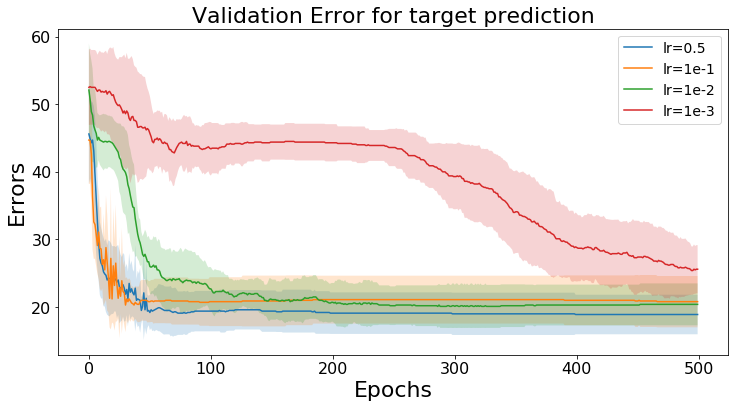

In [165]:
g_names = {'file_name': 'train_m11_hyperparameters_epochs500', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=0.5', 'lr=1e-1','lr=1e-2','lr=1e-3']}

m = [data11_05, data11_1, data11_2, data11_3]
generate_multiple_graphic_loss([mod['error_test'] for mod in m], g_names, save=True)

## Comments: 

from the plot we decide to take model with lr = 0.5 and train up to 70 epochs

##  model 1.2 tunning epochs and learning rate

In [241]:
e12 = 75

data12_1 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=e12, w1=0, lr=1, verbose=2)

Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 38 - test error Net 38.00% 38/100
Training: 100.0 , Error: 18 - test error Net 18.00% 18/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 18 - test error Net 18.00% 18/100
Training: 100.0 , Error: 16 - test error Net 16.00% 16/100
Training: 100.0 , Error: 52 - test error Net 52.00% 52/100
Training: 100.0 , Error: 39 - test error Net 39.00% 39/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Model with 70332 parameters
Mean error: 23.00 Std deviation in error: 14.58


In [242]:
data12_2 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=e12, w1=0, lr=5*1e-1, verbose=2)

Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 23 - test error Net 23.00% 23/100
Training: 100.0 , Error: 16 - test error Net 16.00% 16/100
Training: 100.0 , Error: 19 - test error Net 19.00% 19/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 19 - test error Net 19.00% 19/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Model with 70332 parameters
Mean error: 15.10 Std deviation in error: 4.48


In [243]:
data12_3 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=e12, w1=0, lr=1e-1, verbose=2)

Training: 100.0 , Error: 13 - test error Net 13.00% 13/100
Training: 100.0 , Error: 20 - test error Net 20.00% 20/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Training: 100.0 , Error: 17 - test error Net 17.00% 17/100
Training: 100.0 , Error: 21 - test error Net 21.00% 21/100
Training: 100.0 , Error: 16 - test error Net 16.00% 16/100
Model with 70332 parameters
Mean error: 15.50 Std deviation in error: 3.10


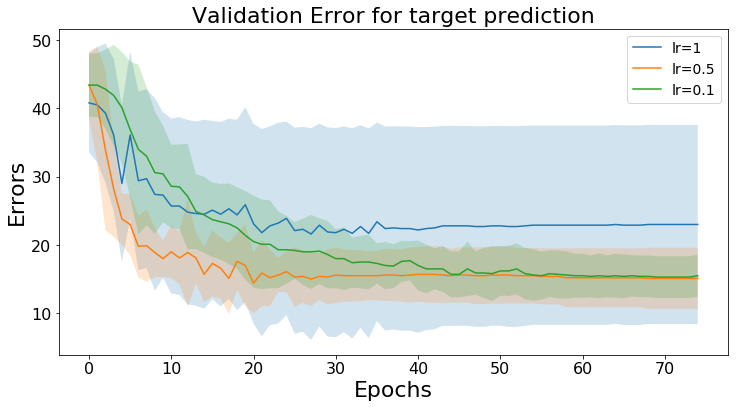

In [244]:
g_names = {'file_name': 'train_m12_hyperparameters', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}

m = [data12_1, data12_2, data12_3]
generate_multiple_graphic_loss([mod['error_test_m2'] for mod in m], g_names, save=True)

## model 2.1 tunning epochs and learning rate

In [245]:
e21 = 50
r=10
data21_1 = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=e21, epochs2=15, version=0, lr=1, verbose=2)

Training: 100.0 %, Error: 2 - test error 2.00% 2/100
Training: 100.0 %, Error: 2 - test error 2.00% 2/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 1 - test error 1.00% 1/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Model with 72684 parameters 	
Mean error: 3.60 Std deviation in error: 1.58


In [246]:
data21_2 = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=e21, epochs2=15, version=0, lr=0.5, verbose=2)

Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 9 - test error 9.00% 9/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 1 - test error 1.00% 1/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 2 - test error 2.00% 2/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Model with 72684 parameters 	
Mean error: 4.60 Std deviation in error: 2.37


In [247]:
data21_3 = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=e21, epochs2=15, version=0, lr=0.1, verbose=2)

Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 11 - test error 11.00% 11/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 2 - test error 2.00% 2/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Model with 72684 parameters 	
Mean error: 5.10 Std deviation in error: 2.47


In [27]:
data21_asd = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=10, epochs2=15, version=0, lr=0.1, verbose=2)

Training: 100.0 %, Error: 12 - test error 12.00% 12/100
Training: 100.0 %, Error: 19 - test error 19.00% 19/100
Training: 100.0 %, Error: 18 - test error 18.00% 18/100
Training: 100.0 %, Error: 9 - test error 9.00% 9/100
Training: 100.0 %, Error: 10 - test error 10.00% 10/100
Training: 100.0 %, Error: 12 - test error 12.00% 12/100
Training: 100.0 %, Error: 12 - test error 12.00% 12/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 11 - test error 11.00% 11/100
Model with 72684 parameters 	
Mean error: 11.60 Std deviation in error: 4.20


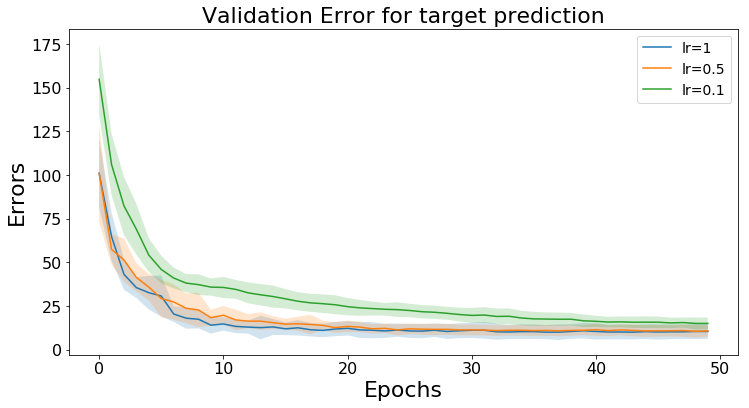

In [248]:
m = [data21_1, data21_2, data21_3]

g_names = {'file_name': 'train_m21_hyperparameters_error_m1', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}
generate_multiple_graphic_loss([mod['error_test_m1'] for mod in m], g_names, save=True)

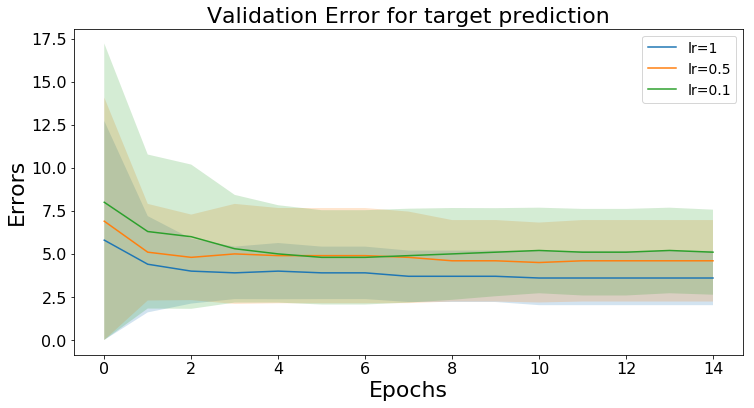

In [249]:
g_names = {'file_name': 'train_m21_hyperparameters_error_m2', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}
generate_multiple_graphic_loss([mod['error_test_m2'] for mod in m], g_names, save=True)

## model 2.2 tunning epochs and learning rate

In [250]:
e22 = 75
data22_1 = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=e22, epochs2=15, version=1, lr=1, verbose=2)

Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 1 - test error 1.00% 1/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Model with 72684 parameters 	
Mean error: 5.10 Std deviation in error: 2.23


In [251]:
data22_2 = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=e22, epochs2=15, version=1, lr=0.5, verbose=2)

Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 14 - test error 14.00% 14/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 9 - test error 9.00% 9/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Model with 72684 parameters 	
Mean error: 6.10 Std deviation in error: 3.41


In [252]:
data22_3 = test_model_separate(112, train_input, train_classes, train_target, runs=r, epochs=e22, epochs2=15, version=1, lr=0.1, verbose=2)

Training: 100.0 %, Error: 14 - test error 14.00% 14/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 11 - test error 11.00% 11/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 2 - test error 2.00% 2/100
Model with 72684 parameters 	
Mean error: 7.70 Std deviation in error: 3.16


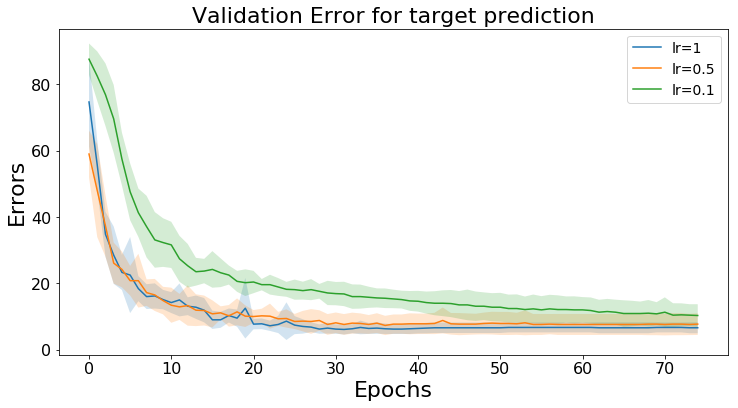

In [253]:
m = [data22_1, data22_2, data22_3]

g_names = {'file_name': 'train_m22_hyperparameters_error_m12', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}
generate_multiple_graphic_loss([mod['error_test_m12'] for mod in m], g_names, save=True)

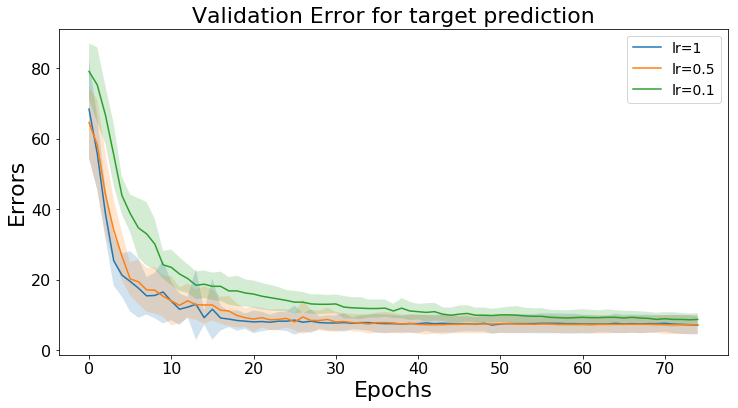

In [254]:
g_names = {'file_name': 'train_m22_hyperparameters_error_m11', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}
generate_multiple_graphic_loss([mod['error_test_m1'] for mod in m], g_names, save=True)

## model 3.1 tunning epochs and learning rate

In [257]:
e31=75
data31_1 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=e31, lr=1, verbose=2)


Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 7 - test error Net 7.00% 7/100
Training: 100.0 , Error: 46 - test error Net 46.00% 46/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 7 - test error Net 7.00% 7/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 13 - test error Net 13.00% 13/100
Training: 100.0 , Error: 25 - test error Net 25.00% 25/100
Model with 70332 parameters
Mean error: 14.90 Std deviation in error: 12.13


In [258]:
data31_2 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=e31, lr=5*1e-1, verbose=2)


Training: 100.0 , Error: 5 - test error Net 5.00% 5/100
Training: 100.0 , Error: 29 - test error Net 29.00% 29/100
Training: 100.0 , Error: 44 - test error Net 44.00% 44/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 9 - test error Net 9.00% 9/100
Training: 100.0 , Error: 20 - test error Net 20.00% 20/100
Training: 100.0 , Error: 5 - test error Net 5.00% 5/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 4 - test error Net 4.00% 4/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Model with 70332 parameters
Mean error: 14.90 Std deviation in error: 12.78


In [259]:
data31_3 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=e31, lr=1e-1, verbose=2)


Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 13 - test error Net 13.00% 13/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 18 - test error Net 18.00% 18/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 13 - test error Net 13.00% 13/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Model with 70332 parameters
Mean error: 13.20 Std deviation in error: 2.20


In [111]:
# increase epochs to 120 (2**4, 2**5, 2**4) - Adadelta 0.1
data31_4 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=120, lr=1e-1, verbose=2)


Training: 100.0 , Error: 9 - test error Net 9.00% 9/100
Training: 100.0 , Error: 13 - test error Net 13.00% 13/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 17 - test error Net 17.00% 17/100
Training: 100.0 , Error: 18 - test error Net 18.00% 18/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 9 - test error Net 9.00% 9/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 17 - test error Net 17.00% 17/100
Training: 100.0 , Error: 17 - test error Net 17.00% 17/100
Model with 21116 parameters
Mean error: 12.80 Std deviation in error: 4.05


In [114]:
# increase epochs to 120 (2**4, 2**5, 2**4) SGD 
data31_4_SGD = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=120, lr=1e-1, verbose=2)



Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 13 - test error Net 13.00% 13/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Model with 21116 parameters
Mean error: 11.00 Std deviation in error: 2.54


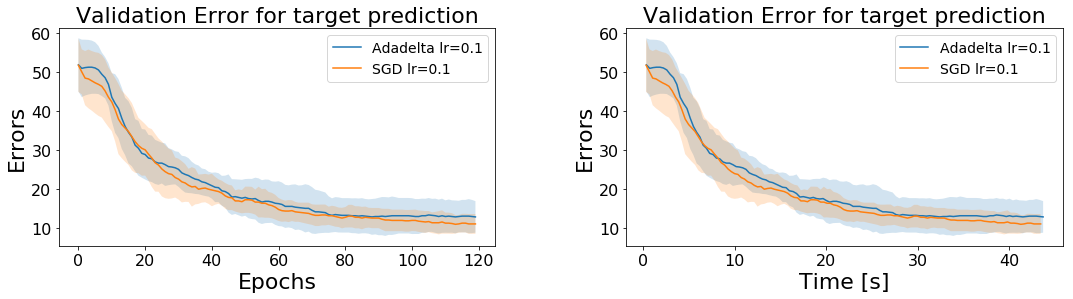

In [115]:
m = [data31_4, data31_4_SGD]
g_names = {'file_name': 'train_m31_optimizers', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['Adadelta lr=0.1', 'SGD lr=0.1']}
generate_multiple_graphic_loss([mod['error_test_m2'] for mod in m], g_names, [mod['time'] for mod in m], save=True)

In [67]:
# increase epochs to 120
data31_5 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=120, lr=1e-1, verbose=2)


Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 16 - test error Net 16.00% 16/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Model with 9596 parameters
Mean error: 11.50 Std deviation in error: 2.17


In [71]:
# increase epochs to 120
data31_6 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=120, lr=1e-1, verbose=2)


Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 6 - test error Net 6.00% 6/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 4 - test error Net 4.00% 4/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 6 - test error Net 6.00% 6/100
Training: 100.0 , Error: 9 - test error Net 9.00% 9/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Model with 18604 parameters
Mean error: 9.50 Std deviation in error: 3.34


In [75]:
# increase epochs to 120
data31_7 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=120, lr=1e-1, verbose=2)


Training: 100.0 , Error: 18 - test error Net 18.00% 18/100
Training: 100.0 , Error: 9 - test error Net 9.00% 9/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 5 - test error Net 5.00% 5/100
Training: 100.0 , Error: 7 - test error Net 7.00% 7/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 10 - test error Net 10.00% 10/100
Training: 100.0 , Error: 14 - test error Net 14.00% 14/100
Model with 13828 parameters
Mean error: 10.50 Std deviation in error: 3.57


In [78]:
# increase epochs to 120
data31_8 = test_model_joint(train_input, train_classes, train_target, runs=r, epochs=120, lr=1e-1, verbose=2)


Training: 100.0 , Error: 5 - test error Net 5.00% 5/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 6 - test error Net 6.00% 6/100
Training: 100.0 , Error: 15 - test error Net 15.00% 15/100
Training: 100.0 , Error: 12 - test error Net 12.00% 12/100
Training: 100.0 , Error: 8 - test error Net 8.00% 8/100
Training: 100.0 , Error: 7 - test error Net 7.00% 7/100
Training: 100.0 , Error: 7 - test error Net 7.00% 7/100
Training: 100.0 , Error: 11 - test error Net 11.00% 11/100
Model with 218244 parameters
Mean error: 9.00 Std deviation in error: 3.13


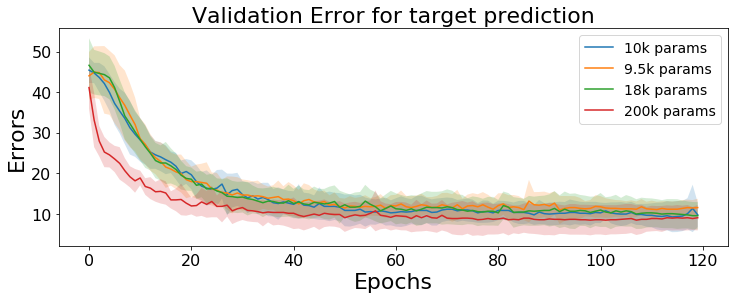

In [91]:
m = [data31_4, data31_5,  data31_6, data31_8]
g_names = {'file_name': 'train_m31_size_net', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['10k params', '9.5k params', '18k params', '200k params']}
generate_multiple_graphic_loss([mod['error_test_m2'] for mod in m], g_names, save=True)

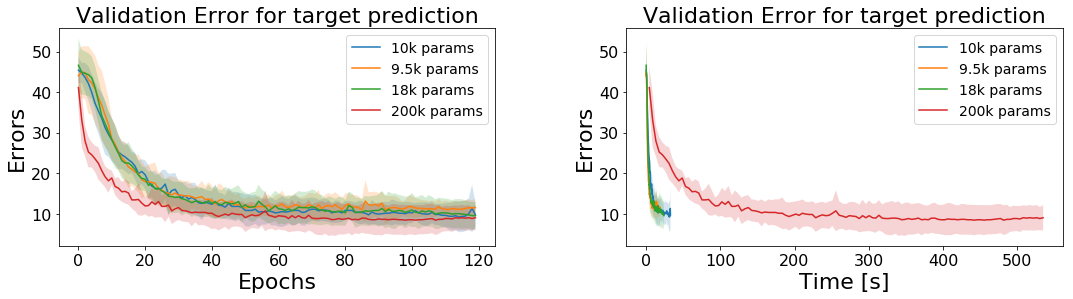

In [99]:
g_names = {'file_name': 'train_m31_size_net_error_test_time', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['10k params', '9.5k params', '18k params', '200k params']}
generate_multiple_graphic_loss([mod['error_test_m2'] for mod in m], g_names, [mod['time'] for mod in m],save=True)

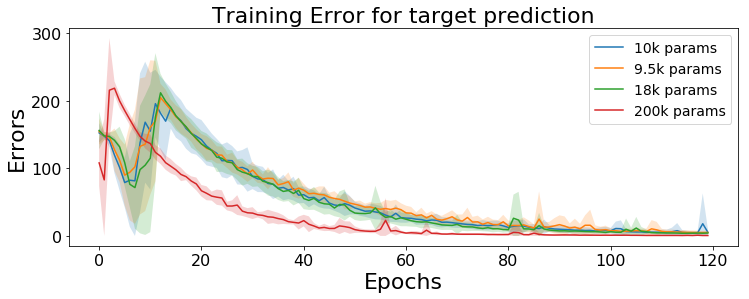

In [89]:
g_names = {'file_name': 'train_m31_size_net_training_error', 'title': 'Training Error for target prediction', 'y_axis': 'Errors' , 'legend': ['10k params', '9.5k params', '18k params', '200k params']}
generate_multiple_graphic_loss([mod['error_m2'] for mod in m], g_names, save=True)

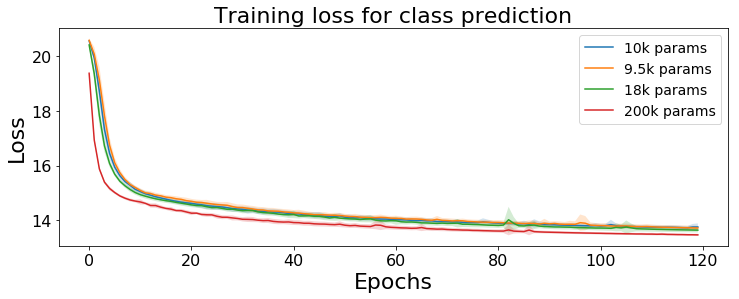

In [92]:
g_names = {'file_name': 'train_m31_size_net_loss_m1', 'title': 'Training loss for class prediction', 'y_axis': 'Loss' , 'legend': ['10k params', '9.5k params', '18k params', '200k params']}
generate_multiple_graphic_loss([mod['loss_m1'] for mod in m], g_names, save=True)

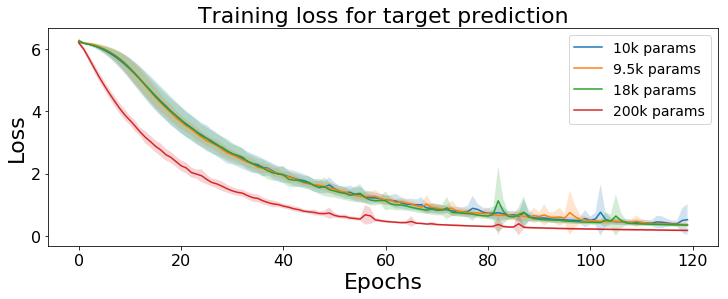

In [93]:
g_names = {'file_name': 'train_m31_size_net_loss_m2', 'title': 'Training loss for target prediction', 'y_axis': 'Loss' , 'legend': ['10k params', '9.5k params', '18k params', '200k params']}
generate_multiple_graphic_loss([mod['loss_m2'] for mod in m], g_names, save=True)

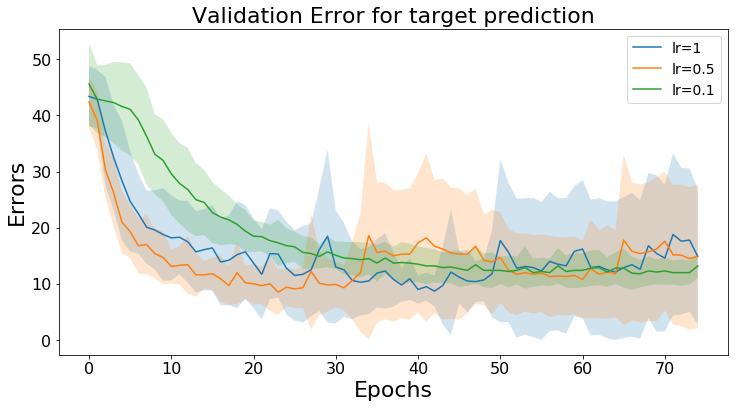

In [260]:
g_names = {'file_name': 'train_m31_hyperparameters', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}
generate_multiple_graphic_loss([data31_1['error_test_m2'], data31_2['error_test_m2'], data31_3['error_test_m2']], g_names, save=True)

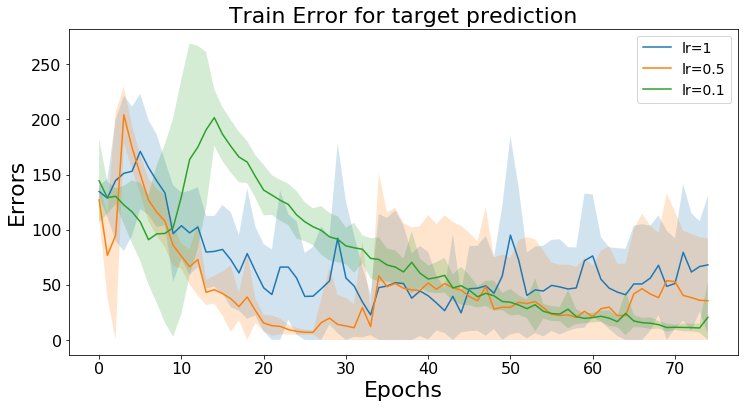

In [261]:
g_names = {'file_name': 'train_m31_hyperparameters_trainerror', 'title': 'Train Error for target prediction', 'y_axis': 'Errors' , 'legend': ['lr=1','lr=0.5','lr=0.1']}
generate_multiple_graphic_loss([data31_1['error_m2'], data31_2['error_m2'], data31_3['error_m2']], g_names, save=True)

# -----------

# COMPARISON BETWEEN MODELS IN TEST SET

In [117]:
# evaluate model 1.1 in TEST set
d_model_11 = test_model_fc(train_input, train_classes, train_target, test_input, test_classes, test_target, runs=r, epochs=200, l_rate=1e-1, verbose=3)

 - test error Net 20.00% 205/1000
 - test error Net 19.00% 199/1000
 - test error Net 18.00% 188/1000
 - test error Net 19.00% 195/1000
 - test error Net 19.00% 198/1000
 - test error Net 18.00% 187/1000


KeyboardInterrupt: 

In [30]:
# evaluate model 1.2 in TEST set
d_model_12 = test_model_joint(train_input, train_classes, train_target, test_input, test_classes, test_target, runs=r, epochs=25, w1=0, lr=5*1e-1, verbose=2)

Training: 100.0 , Error: 111 - test error Net 11.00% 111/1000
Training: 100.0 , Error: 119 - test error Net 11.00% 119/1000
Training: 100.0 , Error: 131 - test error Net 13.00% 131/1000
Training: 100.0 , Error: 99 - test error Net 9.00% 99/1000
Training: 100.0 , Error: 116 - test error Net 11.00% 116/1000
Training: 100.0 , Error: 109 - test error Net 10.00% 109/1000
Training: 100.0 , Error: 119 - test error Net 11.00% 119/1000
Training: 100.0 , Error: 120 - test error Net 12.00% 120/1000
Training: 100.0 , Error: 118 - test error Net 11.00% 118/1000
Training: 100.0 , Error: 123 - test error Net 12.00% 123/1000
Model with 70332 parameters
Mean error: 11.10 Std deviation in error: 1.10


In [28]:
# evaluate model 2.1 in TEST set
d_model_21 = test_model_separate(train_input, train_classes, train_target, test_input, test_classes, test_target, runs=r, epochs=30, epochs2=15, version=0, lr=0.5, verbose=2)

Training: 100.0 %, Error: 391 - test error 3.00% 39/1000
Training: 100.0 %, Error: 472 - test error 4.00% 47/1000
Training: 100.0 %, Error: 430 - test error 4.00% 43/1000
Training: 100.0 %, Error: 34 - test error 3.00% 34/1000
Training: 100.0 %, Error: 35 - test error 3.00% 35/1000
Training: 100.0 %, Error: 38 - test error 3.00% 38/1000
Training: 100.0 %, Error: 34 - test error 3.00% 34/1000
Training: 100.0 %, Error: 355 - test error 3.00% 35/1000
Training: 100.0 %, Error: 402 - test error 4.00% 40/1000
Training: 100.0 %, Error: 390 - test error 3.00% 39/1000
Model with 72684 parameters 	
Mean error: 3.30 Std deviation in error: 0.48


In [29]:
# evaluate model 2.2 in TEST set
d_model_22 = test_model_separate(train_input, train_classes, train_target, test_input, test_classes, test_target, runs=r, epochs=30, epochs2=15, version=1, lr=0.5, verbose=2)

Training: 100.0 %, Error: 48 - test error 4.00% 48/1000
Training: 100.0 %, Error: 47 - test error 4.00% 47/1000
Training: 100.0 %, Error: 58 - test error 5.00% 58/1000
Training: 100.0 %, Error: 63 - test error 6.00% 63/1000
Training: 100.0 %, Error: 55 - test error 5.00% 55/1000
Training: 100.0 %, Error: 58 - test error 5.00% 58/1000
Training: 100.0 %, Error: 59 - test error 5.00% 59/1000
Training: 100.0 %, Error: 50 - test error 5.00% 50/1000
Training: 100.0 %, Error: 49 - test error 4.00% 49/1000
Training: 100.0 %, Error: 49 - test error 4.00% 49/1000
Model with 72684 parameters 	
Mean error: 4.70 Std deviation in error: 0.67


In [32]:
# evaluate model 3.1 in TEST set
d_model_31 = test_model_joint(train_input, train_classes, train_target, test_input, test_classes, test_target, runs=r, epochs=25, lr=5*1e-1, verbose=2, w1=0.6, w2=0.4)

Training: 100.0 , Error: 91 - test error Net 9.00% 91/1000
Training: 100.0 , Error: 80 - test error Net 8.00% 80/1000
Training: 100.0 , Error: 97 - test error Net 9.00% 97/1000
Training: 100.0 , Error: 100 - test error Net 10.00% 100/1000
Training: 100.0 , Error: 104 - test error Net 10.00% 104/1000
Training: 100.0 , Error: 89 - test error Net 8.00% 89/1000
Training: 100.0 , Error: 94 - test error Net 9.00% 94/1000
Training: 100.0 , Error: 102 - test error Net 10.00% 102/1000
Training: 100.0 , Error: 77 - test error Net 7.00% 77/1000
Training: 100.0 , Error: 98 - test error Net 9.00% 98/1000
Model with 70332 parameters
Mean error: 8.90 Std deviation in error: 0.99


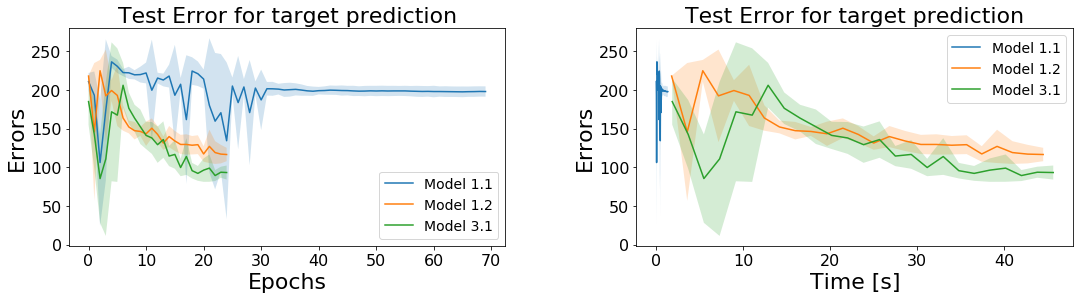

In [116]:
# generate graphic to compare single models in terms of errors along epochs and time
m = [d_model_11, d_model_12, d_model_31]
l = ['Model 1.1', 'Model 1.2', 'Model 3.1']

g_names = {'file_name': 'comparison_single_models', 'title': 'Test Error for target prediction', 'y_axis': 'Errors' , 'legend': l}
generate_multiple_graphic_loss([d_model_11['error_test'], d_model_12['error_test_m2'], d_model_31['error_test_m2']], g_names, [mod['time'] for mod in m],save=True)

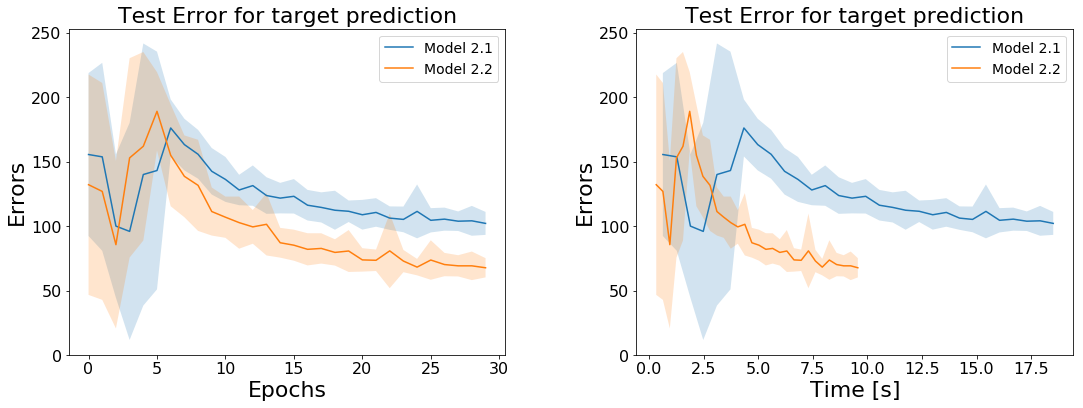

In [39]:
# generate graphic to compare combined models in terms of errors along epochs and time
m = [d_model_21, d_model_22]
l = ['Model 2.1', 'Model 2.2']

g_names = {'file_name': 'comparison_combined_models', 'title': 'Test Error for target prediction', 'y_axis': 'Errors' , 'legend': l}
generate_multiple_graphic_loss([d_model_21['error_test_m1'], d_model_22['error_test_m1']], g_names, [mod['time_m1'] for mod in m],save=True)

# --------------------------

In [23]:
data11 = test_model_fc(train_input, train_classes_one_hot, train_target, runs=r, epochs=40, l_rate=1e-1, verbose=2)

Training: 100.0 %, Error: 21 - test error Net 21.00% 21/100
Training: 100.0 %, Error: 14 - test error Net 14.00% 14/100
Training: 100.0 %, Error: 22 - test error Net 22.00% 22/100
Training: 100.0 %, Error: 25 - test error Net 25.00% 25/100
Training: 100.0 %, Error: 27 - test error Net 27.00% 27/100
Training: 100.0 %, Error: 16 - test error Net 16.00% 16/100
Training: 100.0 %, Error: 22 - test error Net 22.00% 22/100
Training: 100.0 %, Error: 22 - test error Net 22.00% 22/100
Training: 100.0 %, Error: 23 - test error Net 23.00% 23/100
Training: 100.0 %, Error: 15 - test error Net 15.00% 15/100
Model with 75202 parameters
Mean error: 20.70 Std deviation in error: 4.32


In [31]:
r = 10
e = 25 #25
data12 = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, w1=0, lr=5*1e-1, verbose=2)


Training: 100.0 , Error: 15% - test error Net 15.00% 15/100
Training: 100.0 , Error: 16% - test error Net 16.00% 16/100
Training: 100.0 , Error: 12% - test error Net 12.00% 12/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Training: 100.0 , Error: 9% - test error Net 9.00% 9/100
Training: 100.0 , Error: 16% - test error Net 16.00% 16/100
Training: 100.0 , Error: 10% - test error Net 10.00% 10/100
Training: 100.0 , Error: 13% - test error Net 13.00% 13/100
Training: 100.0 , Error: 15% - test error Net 15.00% 15/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Model with 70332 parameters
Mean error: 13.10 Std deviation in error: 2.51


In [32]:
data31 = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2)

Training: 100.0 , Error: 1% - test error Net 1.00% 1/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Training: 100.0 , Error: 10% - test error Net 10.00% 10/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 12% - test error Net 12.00% 12/100
Training: 100.0 , Error: 10% - test error Net 10.00% 10/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Model with 70332 parameters
Mean error: 9.40 Std deviation in error: 3.92


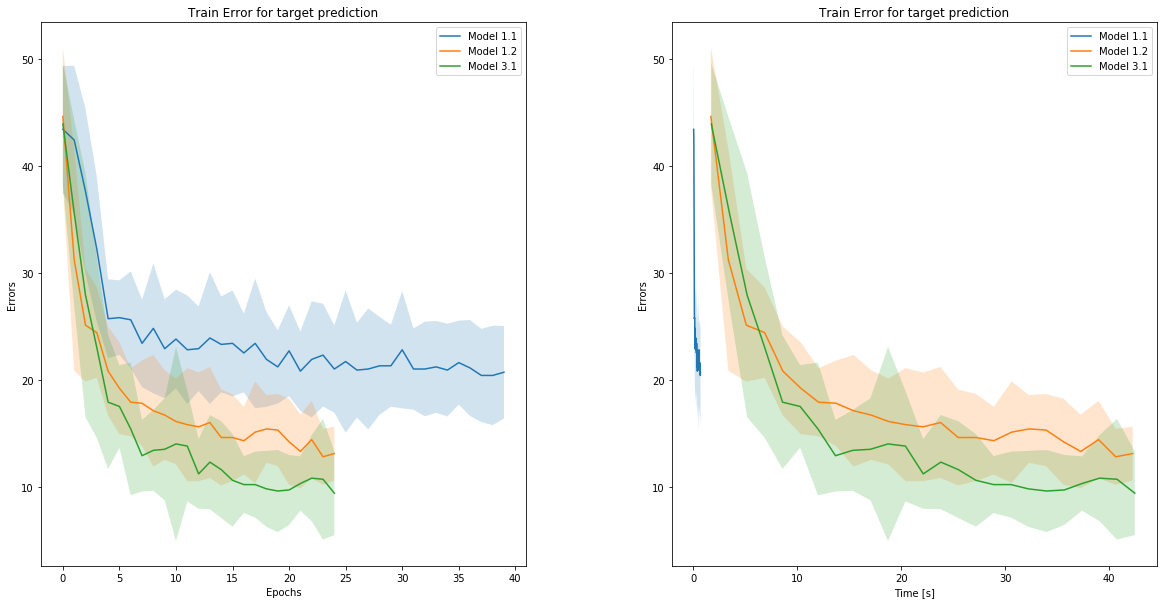

In [44]:
g_names = {'file_name': 'train_separate_m2_short_trial', 'title': 'Train Error for target prediction', 'y_axis': 'Errors' , 'legend': ['Model 1.1', 'Model 1.2', 'Model 3.1']}
generate_multiple_graphic_loss([data11['error_test'], data12['error_test_m2'], data31['error_test_m2']], g_names, [data11['time'], data12['time'], data31['time']], save=True)


In [46]:
data21 = test_model_separate(112, train_input, train_classes_one_hot, train_target, runs=r, epochs=25, epochs2=15, version=0, lr=0.5, verbose=2)

Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Model with 72684 parameters 	
Mean error: 3.90 Std deviation in error: 1.37


In [47]:
data22 = test_model_separate(112, train_input, train_classes_one_hot, train_target, runs=r, epochs=25, epochs2=15, version=1, lr=0.5, verbose=2)


Training: 100.0 %, Error: 10 - test error 10.00% 10/100
Training: 100.0 %, Error: 3 - test error 3.00% 3/100
Training: 100.0 %, Error: 9 - test error 9.00% 9/100
Training: 100.0 %, Error: 5 - test error 5.00% 5/100
Training: 100.0 %, Error: 4 - test error 4.00% 4/100
Training: 100.0 %, Error: 9 - test error 9.00% 9/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Training: 100.0 %, Error: 6 - test error 6.00% 6/100
Training: 100.0 %, Error: 7 - test error 7.00% 7/100
Training: 100.0 %, Error: 8 - test error 8.00% 8/100
Model with 72684 parameters 	
Mean error: 6.90 Std deviation in error: 2.33


In [54]:
data22.keys()

dict_keys(['loss_m1', 'loss_m2', 'time_m1', 'time_m2', 'nb_error_test', 'error_m2', 'error_test_m1', 'error_test_m2', 'loss_m12', 'time_m12', 'error_test_m12'])

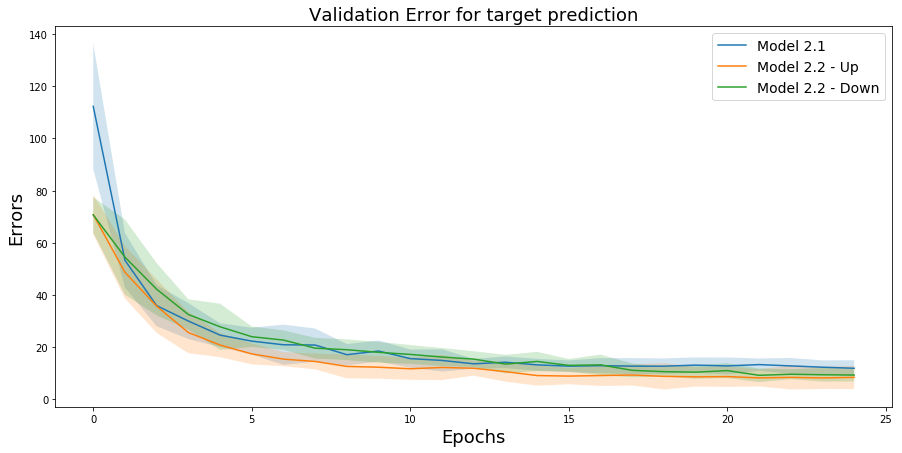

In [127]:
g_names = {'file_name': 'comparison_m11_m12_error_m1', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['Model 2.1', 'Model 2.2 - Up','Model 2.2 - Down']}
generate_multiple_graphic_loss([data21['error_test_m1'], data22['error_test_m1'], data22['error_test_m12']], g_names, save=True)



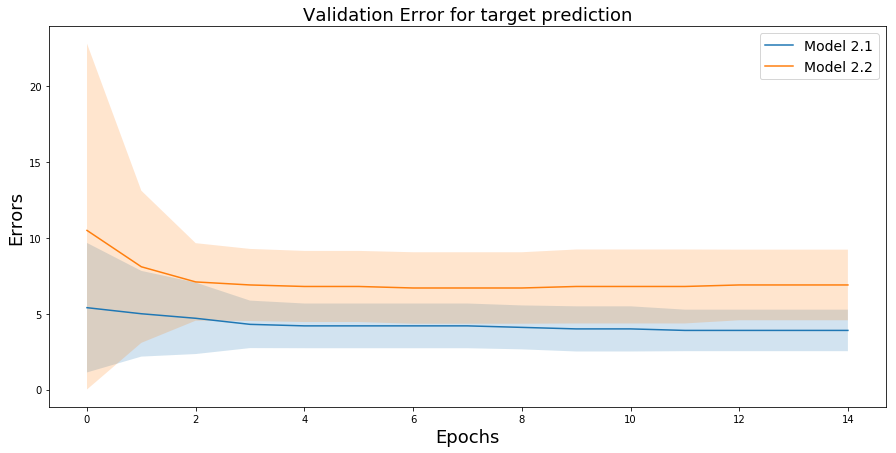

In [128]:
g_names = {'file_name': 'comparison_m11_m12_error_m2', 'title': 'Validation Error for target prediction', 'y_axis': 'Errors' , 'legend': ['Model 2.1', 'Model 2.2']}
generate_multiple_graphic_loss([data21['error_test_m2'], data22['error_test_m2']], g_names, save=True)




## PLOTS FOR COMPARISON OF WEIGHT VALUES OF MODEL 3.1

In [80]:
e = 40

In [81]:
data31 = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2)

Training: 100.0 , Error: 16% - test error Net 16.00% 16/100
Training: 100.0 , Error: 12% - test error Net 12.00% 12/100
Training: 100.0 , Error: 5% - test error Net 5.00% 5/100
Training: 100.0 , Error: 9% - test error Net 9.00% 9/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 10% - test error Net 10.00% 10/100
Training: 100.0 , Error: 5% - test error Net 5.00% 5/100
Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Model with 70332 parameters
Mean error: 9.40 Std deviation in error: 3.37


In [82]:
data31_nw = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2, w1=2)

Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Training: 100.0 , Error: 3% - test error Net 3.00% 3/100
Training: 100.0 , Error: 13% - test error Net 13.00% 13/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 9% - test error Net 9.00% 9/100
Training: 100.0 , Error: 5% - test error Net 5.00% 5/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Model with 70332 parameters
Mean error: 7.30 Std deviation in error: 2.95


In [83]:
data31_hw = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2, w1=0.5, w2=0.5)

Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 12% - test error Net 12.00% 12/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 13% - test error Net 13.00% 13/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Model with 70332 parameters
Mean error: 9.50 Std deviation in error: 3.34


In [84]:
data31_8_2 = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2, w1=0.8, w2=0.2)

Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Training: 100.0 , Error: 10% - test error Net 10.00% 10/100
Training: 100.0 , Error: 5% - test error Net 5.00% 5/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 9% - test error Net 9.00% 9/100
Training: 100.0 , Error: 4% - test error Net 4.00% 4/100
Model with 70332 parameters
Mean error: 8.30 Std deviation in error: 2.95


In [85]:
data31_2_8 = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2, w1=0.2, w2=0.8)

Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 9% - test error Net 9.00% 9/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 13% - test error Net 13.00% 13/100
Training: 100.0 , Error: 12% - test error Net 12.00% 12/100
Training: 100.0 , Error: 9% - test error Net 9.00% 9/100
Training: 100.0 , Error: 12% - test error Net 12.00% 12/100
Training: 100.0 , Error: 22% - test error Net 22.00% 22/100
Training: 100.0 , Error: 13% - test error Net 13.00% 13/100
Training: 100.0 , Error: 14% - test error Net 14.00% 14/100
Model with 70332 parameters
Mean error: 12.30 Std deviation in error: 3.95


In [86]:
data31_6_4 = test_model_joint(train_input, train_classes_one_hot, train_target, runs=r, epochs=e, lr=5*1e-1, verbose=2, w1=0.6, w2=0.4)

Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 11% - test error Net 11.00% 11/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 5% - test error Net 5.00% 5/100
Training: 100.0 , Error: 4% - test error Net 4.00% 4/100
Training: 100.0 , Error: 8% - test error Net 8.00% 8/100
Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Training: 100.0 , Error: 5% - test error Net 5.00% 5/100
Training: 100.0 , Error: 7% - test error Net 7.00% 7/100
Training: 100.0 , Error: 6% - test error Net 6.00% 6/100
Model with 70332 parameters
Mean error: 7.20 Std deviation in error: 2.39


In [87]:
data31.keys()

dict_keys(['loss', 'nb_error_test', 'time', 'loss_m1', 'loss_m2', 'error_m2', 'error_test_m2'])

In [101]:
mod = [data31, data31_hw, data31_8_2, data31_2_8, data31_6_4]
l = ['Model 3.1', 'w1=w2=0.5', 'w1=0.8, w2=0.2', 'w1=0.2, w2=0.8', 'w1=0.6, w2=0.4']

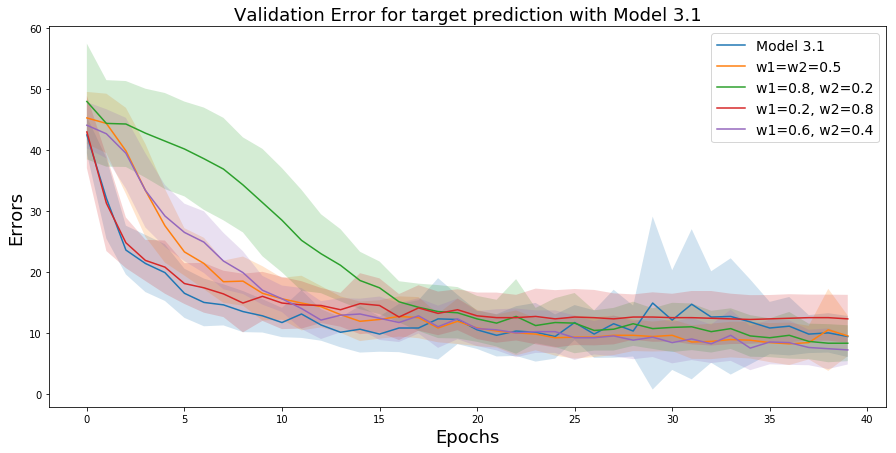

In [126]:
g_names = {'file_name': 'comparisons_test_error_m31', 'title': 'Validation Error for target prediction with Model 3.1', 'y_axis': 'Errors' , 'legend': l}
generate_multiple_graphic_loss([m['error_test_m2'] for m in mod], g_names, save=True)

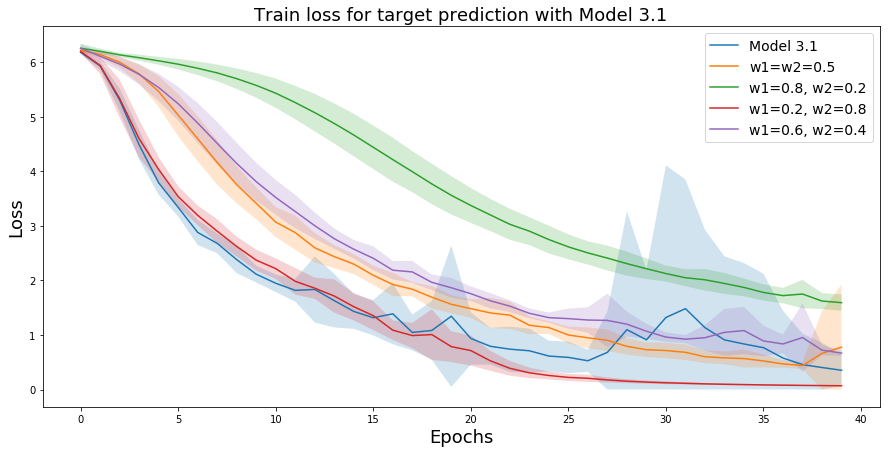

In [118]:
g_names = {'file_name': 'comparisons_loss2_model_31', 'title': 'Train loss for target prediction with Model 3.1', 'y_axis': 'Loss' , 'legend': l}
generate_multiple_graphic_loss([m['loss_m2'] for m in mod], g_names, save=True)

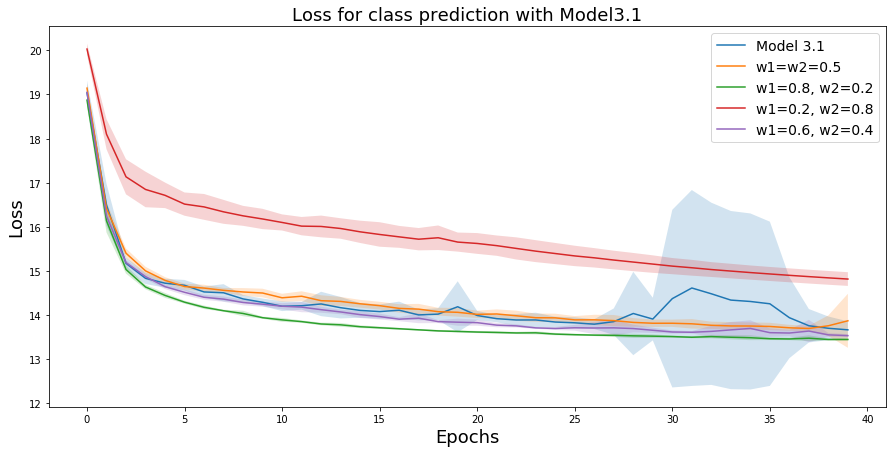

In [119]:
g_names = {'file_name': 'comparisons_loss1_model_31', 'title': 'Loss for class prediction with Model3.1', 'y_axis': 'Loss' , 'legend': l}
generate_multiple_graphic_loss([m['loss_m1'] for m in mod], g_names, save=True)

# TEST MODEL 3.1 WITH TEST SET

In [105]:
data31_64_test = test_model_joint(train_input, train_classes_one_hot, train_target, test_input, test_classes_one_hot, test_target, runs=r, epochs=e, lr=5*1e-1, verbose=2, w1=0.6, w2=0.4)

Training: 100.0 , Error: 95% - test error Net 9.00% 95/1000
Training: 100.0 , Error: 95% - test error Net 9.00% 95/1000
Training: 100.0 , Error: 104% - test error Net 10.00% 104/1000
Training: 100.0 , Error: 103% - test error Net 10.00% 103/1000
Training: 100.0 , Error: 213% - test error Net 21.00% 213/1000
Training: 100.0 , Error: 113% - test error Net 11.00% 113/1000
Training: 100.0 , Error: 90% - test error Net 9.00% 90/1000
Training: 100.0 , Error: 81% - test error Net 8.00% 81/1000
Training: 100.0 , Error: 78% - test error Net 7.00% 78/1000
Training: 100.0 , Error: 80% - test error Net 8.00% 80/1000
Model with 70332 parameters
Mean error: 10.20 Std deviation in error: 3.97


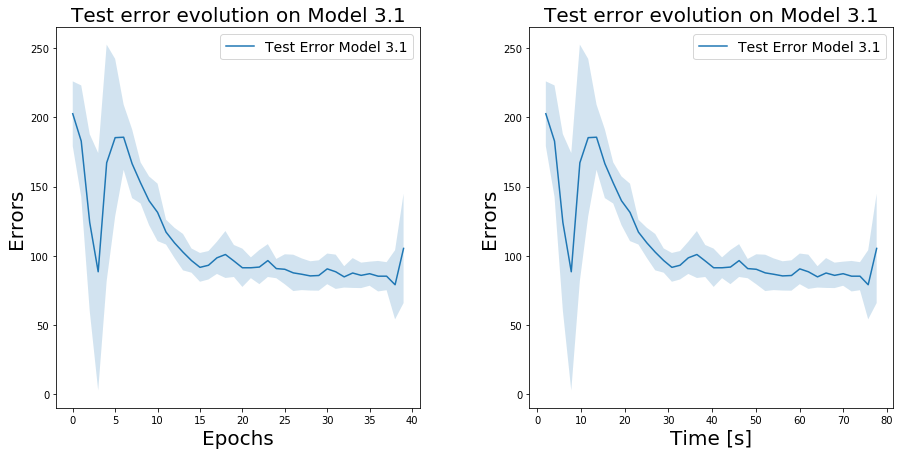

In [129]:
g_names = {'file_name': '', 'title': 'Test error evolution on Model 3.1', 'y_axis': 'Errors' , 'legend': ['Test Error Model 3.1']}
generate_multiple_graphic_loss([data31_64_test['error_test_m2']], g_names, [data31_64_test['time']], save=True)

## NOT THESE ONES! 

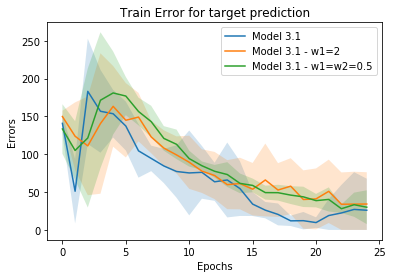

In [62]:
g_names = {'file_name': 'comparison_m11_m12', 'title': 'Train Error for target prediction', 'y_axis': 'Errors' , 'legend': ['Model 3.1', 'Model 3.1 - w1=2', 'Model 3.1 - w1=w2=0.5']}
generate_multiple_graphic_loss([data31['error_m2'], data31_nw['error_m2'], data31_hw['error_m2']], g_names, save=False)

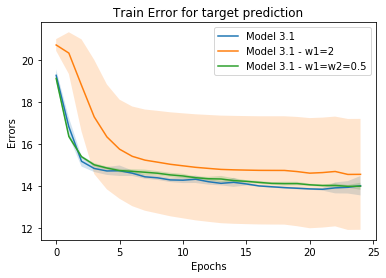

In [63]:
g_names = {'file_name': 'comparison_m11_m12', 'title': 'Train Error for target prediction', 'y_axis': 'Errors' , 'legend': ['Model 3.1', 'Model 3.1 - w1=2', 'Model 3.1 - w1=w2=0.5']}
generate_multiple_graphic_loss([data31['loss_m1'], data31_nw['loss_m1'], data31_hw['loss_m1']], g_names, save=True)